In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# Cross-Validation and Bias-Variance decomposition
## Cross-Validation
Implementing 4-fold cross-validation below:

In [2]:
from helpers import load_data

# load dataset
x, y = load_data()

In [3]:
def build_k_indices(y, k_fold, seed):
    '''
    Build k indices for k-fold.
    '''
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

In [4]:
def standardize(x):
    '''
    Standardize the original data set.
    '''
    mean_x = np.mean(x, axis = 0)
    x = x - mean_x
    stddev_x = np.std(x, axis = 0)
    x = x / stddev_x
    return x, mean_x, stddev_x

In [5]:
def split_data_k_indices(y, x, k_indices, k):
    '''
    Splits the data into test and training data.
    Samples get randomized through 'k_indices' and
    selected through 'k'.
    '''
    mask = np.ones(k_indices.shape, dtype=bool)
    mask[k] = False
    
    # Test data
    x_test = x[k_indices[k]]
    y_test = y[k_indices[k]]
    
    # Train data
    x_train = x[k_indices[mask]]
    y_train = y[k_indices[mask]]
    
    return x_test, y_test, x_train, y_train

Testing splitting method:

In [6]:
def test_split_data_k_indices():
    # Example data for x and y
    example_x = np.array(['x1', 'x2', 'x3', 'x4', 'x5', 'x6'])
    example_y = np.array(['y1', 'y2', 'y3', 'y4', 'y5', 'y6'])

    # 'example_k_indices' remained sorted for output clarity
    example_k_indices = np.array([[0,1], [2,3], [4,5]])

    # With 'example_k >= 0' AND 'example_k < example_k_indices.shape[0]'
    example_k = 1

    # Split data output
    example_x_test, example_y_test, example_x_train, example_y_train = split_data_k_indices(example_y, example_x, example_k_indices, example_k)

    # Debug prints
    print("Test data:")
    print(example_x_test)
    print(example_y_test)
    print("\nTrain data:")
    print(example_x_train)
    print(example_y_train)
    
test_split_data_k_indices()

Test data:
['x3' 'x4']
['y3' 'y4']

Train data:
['x1' 'x2' 'x5' 'x6']
['y1' 'y2' 'y5' 'y6']


In [7]:
from ridge_regression import ridge_regression, compute_mse
from build_polynomial import build_poly

def cross_validation(y, x, k_indices, k, lambda_, degree):
    '''
    Return the loss of ridge regression.
    '''
    # Split data according to 'k_indices' and 'k'
    x_test, y_test, x_train, y_train = split_data_k_indices(y, x, k_indices, k)
    
    # Standardizing testing and training data.
    # Done independently for 'k_fold' value validation (a good value
    # corresponds to lower difference between the mean and stddev 
    # of both sets).
    x_test, x_test_mean, x_test_stddev = standardize(x_test)
    x_train, x_train_mean, x_train_stddev = standardize(x_train)
    
    # Form data with polynomial degree
    tx_test = build_poly(x_test, degree)
    tx_train = build_poly(x_train, degree)

    # Apply ridge regression
    w_opt, rmse_train = ridge_regression(y_train, tx_train, lambda_)
    rmse_test = np.sqrt(compute_mse(y_test, tx_test, w_opt))
    
    # Return loss for train and test data
    return rmse_train, rmse_test

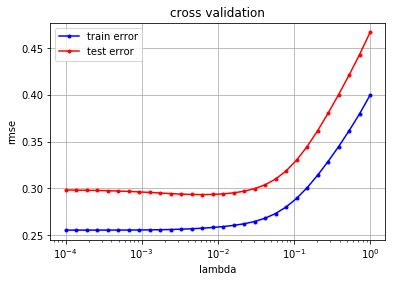

In [8]:
from plots import cross_validation_visualization

def cross_validation_demo():
    seed = 1
    degree = 7
    k_fold = 4
    lambdas = np.logspace(-4, 0, 30)
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    # define lists to store the loss of training data and test data
    rmse_tr = []
    rmse_te = []
    
    # Ridge regression
    for ind, lambda_ in enumerate(lambdas):
        
        rmse_min_dif = float("inf")
        rmse_min_dif_tr = 0
        rmse_min_dif_te = 0
        
        # K-fold cross validation and pick the rmse 'test' and 'train'
        # errors that represent the least absolute difference between
        # them (for a given lambda).
        for k in range(k_fold):
            rmse_cur_tr, rmse_cur_te = cross_validation(y, x, k_indices, k, lambda_, degree)
            rmse_cur_dif = abs(rmse_cur_tr - rmse_cur_te)
            if (rmse_cur_dif < rmse_min_dif):
                rmse_min_dif = rmse_cur_dif
                rmse_min_dif_tr = rmse_cur_tr
                rmse_min_dif_te = rmse_cur_te
                
        rmse_tr.append(rmse_min_dif_tr)
        rmse_te.append(rmse_min_dif_te)
        
    cross_validation_visualization(lambdas, rmse_tr, rmse_te)

cross_validation_demo()

## Bias-Variance Decomposition
Visualize bias-variance trade-off by implementing the function `bias_variance_demo()` below:

In [ ]:
from least_squares import least_squares
from split_data import split_data
from plots import bias_variance_decomposition_visualization

def bias_variance_demo():
    """The entry."""
    # define parameters
    seeds = range(100)
    num_data = 10000
    ratio_train = 0.005
    degrees = range(1, 10)
    
    # define list to store the variable
    rmse_tr = np.empty((len(seeds), len(degrees)))
    rmse_te = np.empty((len(seeds), len(degrees)))
    
    for index_seed, seed in enumerate(seeds):
        np.random.seed(seed)
        x = np.linspace(0.1, 2 * np.pi, num_data)
        y = np.sin(x) + 0.3 * np.random.randn(num_data).T
        # ***************************************************
        # INSERT YOUR CODE HERE
        # split data with a specific seed: TODO
        # ***************************************************
        raise NotImplementedError
        # ***************************************************
        # INSERT YOUR CODE HERE
        # bias_variance_decomposition: TODO
        # ***************************************************
        raise NotImplementedError

    bias_variance_decomposition_visualization(degrees, rmse_tr, rmse_te)

bias_variance_demo()